In [226]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from copy import deepcopy
import json
import pandas as pd
import pickle
import math
import datetime

In [242]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 34

In [243]:
# def get_feature(frame):
#     finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
# #     coordinate = ['x', 'y', 'z']
#     fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
#     feature = np.zeros([22])
#     hand_pos = np.zeros([12])
# #     finger_tip = {}
#     if 'right' in frame['hands']:
#         hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
#                                   frame['hands']['right']['hand_palm_position'][1],
#                                   frame['hands']['right']['hand_palm_position'][2],
#                                   frame['hands']['right']['yaw'], 
#                                   frame['hands']['right']['roll'], 
#                                   frame['hands']['right']['pitch']])
#         for idx, finger in enumerate(finger_name):
# #             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
#             fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
#     if 'left' in frame['hands']:
#         hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
#                                    frame['hands']['left']['hand_palm_position'][1],
#                                    frame['hands']['left']['hand_palm_position'][2],
#                                    frame['hands']['left']['yaw'], 
#                                    frame['hands']['left']['roll'], 
#                                    frame['hands']['left']['pitch']])
# #         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
#         for idx, finger in enumerate(finger_name):
# #             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
#             fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
#     fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
#     feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
#     feature[10:22] = hand_pos

#     return feature

In [231]:
def get_euclid_dis_tips_and_palm_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    dist_fingertip_palm = np.zeros([10])
    dist_btw_fingertip = np.zeros([10])
    
    feature = np.zeros([2*3 + 2*3 + 10 + 10])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
            dist_fingertip_palm[hand_idx*5 + finger_idx] = np.linalg.norm(
                fingertip_pos[hand_idx, finger_idx] - hand_palm_pos[hand_idx]
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_fingertip_palm.T
#     feature[22:32] = dist_btw_fingertip.reshape(10)
    
#     print(feature[12+5:12+6])
#     print(frame['hands']['right']['fingers']['thumb']['bones']['distal']['next_joint'])
#     print(hand_palm_pos[1])
    return feature
    

In [244]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    hand_palm_unit_vector = np.zeros([2, 3])
    arm_direction = np.zeros([2, 3])
    
    feature = np.zeros([34])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        hand_palm_unit_vector[hand_idx] = np.cross(
            frame['hands'][hand]['fingers']['index']['bones']['proximal']['direction'],
            frame['hands'][hand]['fingers']['middle']['bones']['proximal']['direction']
        )
        arm_direction[hand_idx] = np.array(frame['hands'][hand]['arm']['direction'])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_btw_fingertip.reshape(10)
    feature[22:28] = hand_palm_unit_vector.reshape(6)
    feature[28:34] = arm_direction.reshape(6)
    
    return feature
    

In [235]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
#         feature = get_euclid_dis_tips_and_palm_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [6]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [7]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [236]:
def get_augmentation(percent, old_timesteps, old_pick_frame_every_no):
    # percent positive means shrink
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = round(old_pick_frame_every_no*(100+percent)/100)
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        if (start_old_index + 2 > len(old_timesteps)) : break
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps

In [237]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [253]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)
print(pick_frame_every_no)


speedup_max = 1.15
timesteps = 50
augment_timesteps = math.ceil(timesteps * speedup_max) # add speedup
print(augment_timesteps)
timesteps = augment_timesteps

12
58


In [254]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
z = np.zeros([0, timesteps, dimensions])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_augmentation(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        z = np.vstack((z, [__timesteps]))
        y = np.append(y, word_no)

In [120]:
x1 = x

In [128]:
x2 = x

In [141]:
np.linalg.norm(x2[0])

1441.7211756242707

In [142]:
np.linalg.norm(x1[0])

1441.7211756242707

In [118]:
np.linalg.norm(z1-z2)

0.0

In [228]:
with open('./extracted_feature/original_080418GridSearch.pkl', 'rb') as handle:
    [x_original, y_original, x_augment] = pickle.load(handle)

In [261]:
np.linalg.norm(x_augment[0.90] - z)

6123.9303774477239

In [264]:
z[10][10]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.77909463e+01,   3.70523720e+02,   7.84113382e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.37294433e+01,   1.75943431e+01,  -5.28824165e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.12991521e+01,
         4.82661325e+01,   1.82217026e+01,   1.89990077e+01,
         2.33517668e+01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -1.23819111e-01,   9.41811702e-02,
         1.66495845e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -9.28341554e-02,   5.03239787e-02,
        -9.94327287e-01])

In [263]:
x_augment[0.90][10][10]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.77909463e+01,   3.70523720e+02,   7.84113382e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.37294433e+01,   1.75943431e+01,  -5.28824165e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.12991521e+01,
         4.82661325e+01,   1.82217026e+01,   1.89990077e+01,
         2.33517668e+01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -1.23819111e-01,   9.41811702e-02,
         1.66495845e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -9.28341554e-02,   5.03239787e-02,
        -9.94327287e-01])

In [297]:
for i in range((x_augment[0.90][50] - z[50]).shape[0]):
    if (x_augment[0.90][50] - z[50])[i][3] != 0:
        print(i)

29


In [145]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [146]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [147]:
shuffle_train = np.arange(len(x_train))
np.random.seed(0)
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [143]:
x_train_shuffle2 = x_train_shuffle

In [148]:
x_train_shuffle1 = x_train_shuffle

In [150]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [212]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=100, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/100
684/684 [==============================] - 3s 5ms/step - loss: 2.9838 - acc: 0.0482 - val_loss: 2.9497 - val_acc: 0.0526
Epoch 2/100
684/684 [==============================] - 2s 3ms/step - loss: 2.9396 - acc: 0.0643 - val_loss: 2.8927 - val_acc: 0.0702
Epoch 3/100
684/684 [==============================] - 2s 3ms/step - loss: 2.9069 - acc: 0.0789 - val_loss: 2.7973 - val_acc: 0.1550
Epoch 4/100
684/684 [==============================] - 2s 3ms/step - loss: 2.8043 - acc: 0.1082 - val_loss: 2.5845 - val_acc: 0.1228
Epoch 5/100
684/684 [==============================] - 2s 3ms/step - loss: 2.6518 - acc: 0.1038 - val_loss: 2.5491 - val_acc: 0.1520
Epoch 6/100
684/684 [==============================] - 2s 3ms/step - loss: 2.6380 - acc: 0.1140 - val_loss: 2.3084 - val_acc: 0.2018
Epoch 7/100
684/684 [==============================] - 2s 3ms/step - loss: 2.6038 - acc: 0.1462 - val_loss: 2.3950 - val_acc: 0.1667
Epoch 8/100
684/684 [==

Epoch 62/100
684/684 [==============================] - 2s 4ms/step - loss: 1.6874 - acc: 0.3099 - val_loss: 1.3875 - val_acc: 0.4474
Epoch 63/100
684/684 [==============================] - 2s 3ms/step - loss: 1.8140 - acc: 0.3129 - val_loss: 1.4279 - val_acc: 0.4357
Epoch 64/100
684/684 [==============================] - 2s 3ms/step - loss: 1.7095 - acc: 0.3480 - val_loss: 1.3689 - val_acc: 0.4123
Epoch 65/100
684/684 [==============================] - 2s 3ms/step - loss: 1.7303 - acc: 0.3260 - val_loss: 1.3657 - val_acc: 0.4357
Epoch 66/100
684/684 [==============================] - 2s 3ms/step - loss: 1.7353 - acc: 0.3567 - val_loss: 1.3825 - val_acc: 0.4181
Epoch 67/100
684/684 [==============================] - 2s 3ms/step - loss: 1.6925 - acc: 0.3436 - val_loss: 1.3670 - val_acc: 0.4298
Epoch 68/100
684/684 [==============================] - 2s 3ms/step - loss: 1.6633 - acc: 0.3275 - val_loss: 1.3692 - val_acc: 0.4708
Epoch 69/100
684/684 [==============================] - 2s 4ms

In [153]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 921us/step
Test score: 1.06670863935
Test accuracy: 0.578947368421


In [159]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


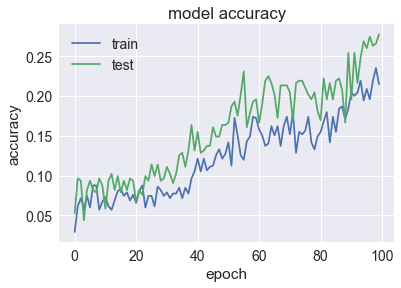

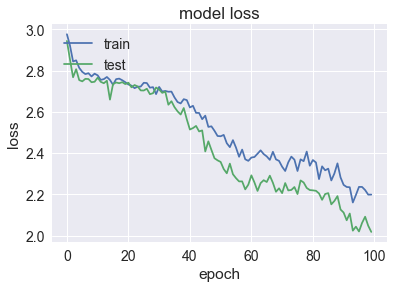

In [160]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
def generate_confusion_matrix(prediction, y_actual, words):
    confusion_matrix = np.zeros([len(words), len(words)])
    prediction_word_index = np.argmax(prediction, axis = 1)

    for idx in range(len(prediction_word_index)):
        actual = y_actual[idx]
        result = prediction_word_index[idx]
        confusion_matrix[int(actual)][result] += 1
        
    return confusion_matrix

In [29]:
def cal_acc(confusion_matrix, words, test_data_per_word):
    test_acc = 0

    for idx in range(len(words)):
        test_acc += confusion_matrix[idx][idx]
    test_acc /= (test_data_per_word * len(words))

    return test_acc

In [30]:
def cal_acc(confusion_matrix, words, test_data_per_word):
    test_acc = 0

    for idx in range(len(words)):
        test_acc += confusion_matrix[idx][idx]
    test_acc /= (test_data_per_word * len(words))

    return test_acc

In [31]:
def predict_and_plot(x_test, y_test, words, test_data_per_word):
    prediction = model.predict(x_test, verbose = 1)
    confusion_matrix = generate_confusion_matrix(prediction, y_test, words)
    print('acc: ', cal_acc(confusion_matrix, words, test_data_per_word))
    plot_confusion_matrix(confusion_matrix, words, words)

In [33]:
def plot_confusion_matrix(confusion_matrix, label_x, label_y):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline

    df_cm = pd.DataFrame(confusion_matrix, label_x, label_y)
    plt.figure(figsize = (15,12))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

342/342 [==============================] - 0s 207us/step
acc:  0.859649122807


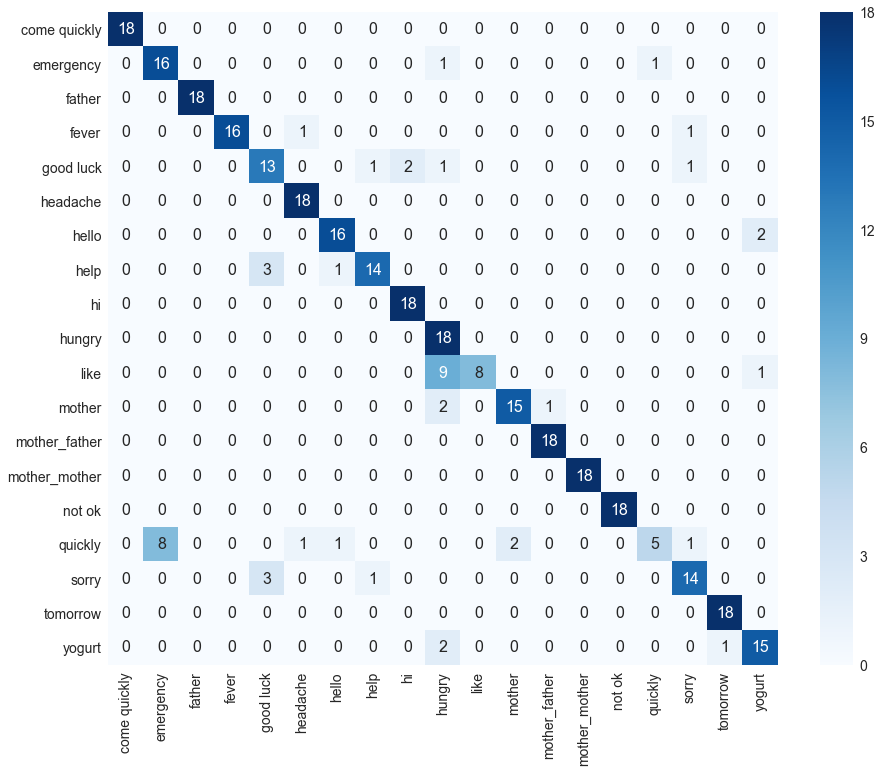

In [34]:
predict_and_plot(x_test, y_test, words, test_data_per_word = 18)

In [ ]:
x_predict = np.zeros([0, timesteps, dimensions])
y_actual = np.zeros([0])

test_data_per_word = 10

for word_no, word in enumerate(words):
    for data_no in range(test_data_per_word):
        try:
            with open("./record_test/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)

        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_predict = np.vstack((x_predict, [_timesteps]))
        y_actual = np.append(y_actual, word_no)
        
x_predict_norm = (x_predict-x_mean)/x_std
    
predict_and_plot(x_test = x_predict_norm, y_test = y_actual, words = words, test_data_per_word = 10)